In [1]:
from applications import image_denoising
from models import ConvAutoencoderLuma
from dataloaders import SimpleLoader2d

import os
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
model = ConvAutoencoderLuma().to(device)

In [2]:
name_model = "model_1"
name_dataset = "gcg2"
path_base = "/home/amedvedev/fprojects/cpp/gcg_2d_minimal/data/"

path_save_model = os.path.join("../assets/pt/", f"{name_dataset}_{name_model}.pt")

try:
    model = torch.load(path_save_model).to(device)
except Exception as e:
    print("Error when loading pretrained model. Use custom.")
    model = ConvAutoencoderLuma().to(device)

In [3]:
BATCH_SIZE = 64

path_save_train_plots = os.path.join("../assets/runs/train_plots", name_dataset, name_model)

path_train = os.path.join(path_base, name_dataset, "train")
path_test = os.path.join(path_base, name_dataset, "val")

path_train_rainy = path_train + "/noised"
path_test_rainy = path_test + "/noised"

path_train_normal = path_train + "/clear"
path_test_normal = path_test + "/clear"


width, height = 60, 60

train_noisy_loader = SimpleLoader2d(path_train_rainy, device, BATCH_SIZE, width, height)
train_normal_loader = SimpleLoader2d(path_train_normal, device, BATCH_SIZE, width, height)

val_noisy_loader =SimpleLoader2d(path_test_rainy, device, BATCH_SIZE, width, height)
val_normal_loader =SimpleLoader2d(path_test_normal, device, BATCH_SIZE, width, height)




In [4]:
def plot_step_results():
    save_results(model, device, path_save_train_plots, train_noisy_loader, train_normal_loader, "train",
                                 limit=1, nrow=32, op_count=1)
    save_results(model, device, path_save_train_plots, val_noisy_loader, val_normal_loader, "test",
                                 limit=1, nrow=32, op_count=1)
    print(f"Step results plotted to {path_save_train_plots}.")



In [ ]:
train_losses, test_losses = [], []

In [20]:
EPOCHS = 10

train_hist = image_denoising.train(model, train_noisy_loader, train_normal_loader, val_noisy_loader, val_normal_loader,
                      EPOCHS, device, path_save=path_save_model, callbacks=[plot_step_results])
train_losses += train_hist[0]
test_losses += train_hist[1]

/home/amedvedev/fprojects/python/denoising/venv/lib/python3.10/site-packages/torch/_tensor.py:836: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Step results plotted to ../assets/runs/train_plots/gcg/model_1.
Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 1 	Training Loss: 0.954643 	Validating Loss: 2.615433 	Time: 4.98 m
Step results plotted to ../assets/runs/train_plots/gcg/model_1.


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 2 	Training Loss: 1.101294 	Validating Loss: 2.451659 	Time: 4.28 m
Step results plotted to ../assets/runs/train_plots/gcg/model_1.


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 3 	Training Loss: 1.023683 	Validating Loss: 2.337772 	Time: 4.31 m
Step results plotted 

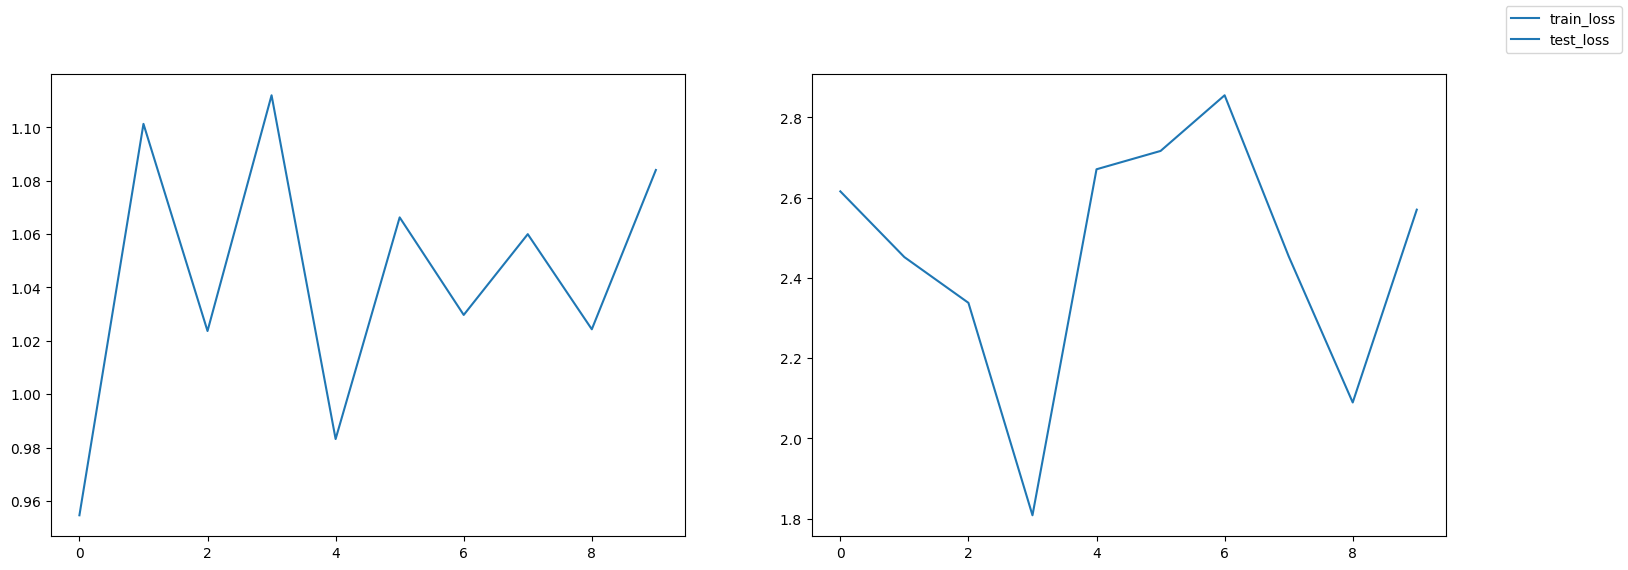

In [21]:
import matplotlib.pyplot as plt
xs = range(EPOCHS)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].plot(xs, train_losses, label="train_loss")
axes[1].plot(xs, test_losses, label="test_loss")
fig.legend()


In [11]:
plot_step_results()

Step results plotted to ../assets/runs/train_plots/gcg/model_1.


In [19]:
image_denoising.save_full_model(model, path_save_model)

In [6]:
path_save_model_onnx = os.path.join("../assets/onnx/", f"{name_dataset}_{name_model}.onnx")
inp = torch.randn((1, 1, width, height), device=device)
image_denoising.save_onnx_model(model, path_save_model_onnx, inp)

Exported graph: graph(%img : Float(1, 1, 100, 100, strides=[10000, 10000, 100, 1], requires_grad=0, device=cuda:0),
      %all_layers.0.weight : Float(76, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cuda:0),
      %all_layers.0.bias : Float(76, strides=[1], requires_grad=1, device=cuda:0),
      %all_layers.3.weight : Float(38, 76, 2, 2, strides=[304, 4, 2, 1], requires_grad=1, device=cuda:0),
      %all_layers.3.bias : Float(38, strides=[1], requires_grad=1, device=cuda:0),
      %all_layers.6.weight : Float(38, 38, 2, 2, strides=[152, 4, 2, 1], requires_grad=1, device=cuda:0),
      %all_layers.6.bias : Float(38, strides=[1], requires_grad=1, device=cuda:0),
      %all_layers.9.weight : Float(38, 38, 2, 2, strides=[152, 4, 2, 1], requires_grad=1, device=cuda:0),
      %all_layers.9.bias : Float(38, strides=[1], requires_grad=1, device=cuda:0),
      %all_layers.11.weight : Float(38, 76, 2, 2, strides=[304, 4, 2, 1], requires_grad=1, device=cuda:0),
      %all_layers.11.bia

In [22]:
import gc

model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

In [5]:
from torchvision.utils import save_image, make_grid

def save_results(model, device, directory, rainy_loader, normal_loader, prefix, limit, nrow=5, op_count=1):

    assert op_count > 0 # кол-во раз обработки изображения моделью
    with torch.no_grad():
      i = 0
      for data_noisy, data_normal in zip(rainy_loader, normal_loader):
            images_noisy, _ = data_noisy
            images_noisy = images_noisy.to(device)

            images_normal, __ = data_normal
            images_normal = images_normal.to(device)

            outputs = model(images_noisy)

            for j in range(op_count):
                res_cat = torch.cat((images_noisy, outputs, images_normal))

                img = make_grid(res_cat, nrow = nrow) # метод делает сетку из картинок
                #img = img.numpy().transpose((1, 2, 0)) # транспонируем для отображения в картинке

                if not os.path.exists(directory):
                  os.makedirs(directory)

                if not os.path.exists(os.path.join(directory, "txt")):
                  os.makedirs(os.path.join(directory, "txt"))
                save_image(img, os.path.join(directory, f"{prefix}_res{i}_op_count({j + 1}).png"))

                res_cat = torch.cat((outputs - images_normal, ))

                img = make_grid(res_cat, nrow = nrow) # метод делает сетку из картинок
                #img = img.numpy().transpose((1, 2, 0)) # транспонируем для отображения в картинке


                save_image(img, os.path.join(directory, f"{prefix}_res{i}_op_count({j + 1})_diff.png"))

                for k in range(BATCH_SIZE):
                    with open(os.path.join(directory, "txt", f"BATCH_ELEMENT_{k}_{prefix}_res{i}_op_count({j + 1})_clear.txt"), "w") as file_write:
                        lst_data = (images_normal[k] * 50.).resize(width, height).tolist()
                        for row_ld in lst_data:
                            for col_ld in row_ld:
                                print(round(col_ld, 3), file=file_write, end=" ")
                        print(file=file_write)

                    with open(os.path.join(directory, "txt",  f"BATCH_ELEMENT_{k}_{prefix}_res{i}_op_count({j + 1})_noised.txt"), "w") as file_write:
                        lst_data = (images_noisy[k] * 50.).resize(width, height).tolist()
                        for row_ld in lst_data:
                            for col_ld in row_ld:
                                print(round(col_ld, 3), file=file_write, end=" ")
                        print(file=file_write)

                    with open(os.path.join(directory, "txt",  f"BATCH_ELEMENT_{k}_{prefix}_res{i}_op_count({j + 1})_out.txt"), "w") as file_write:
                        lst_data = (outputs[k] * 50.).resize(width, height).tolist()
                        for row_ld in lst_data:
                            for col_ld in row_ld:
                                print(round(col_ld, 3), file=file_write, end=" ")
                        print(file=file_write)

                    with open(os.path.join(directory, "txt",  f"BATCH_ELEMENT_{k}_{prefix}_res{i}_op_count({j + 1})_diff.txt"), "w") as file_write:
                        lst_data = ((outputs[k] - images_normal[k]) * 50.).resize(width, height).tolist()
                        for row_ld in lst_data:
                            for col_ld in row_ld:
                                print(round(col_ld, 3), file=file_write, end=" ")
                        print(file=file_write)

                if op_count > 1:
                  outputs = model(outputs)


            i+= 1
            if i >= limit:
              break


In [38]:
plot_step_results()

/home/amedvedev/fprojects/python/denoising/venv/lib/python3.10/site-packages/torch/_tensor.py:836: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Step results plotted to ../assets/runs/train_plots/gcg/model_1.
